# 0. Setup: imports and path
### One-line description: import required libraries and set dataset path.

In [74]:
import pandas as pd
import numpy as np

# For scaling and encoding
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy import stats

# File path (already uploaded)
csv_path = r"Universities_Schoolarships_All_Around_the_World.csv"


# 1. Load the data
### load CSV into a Pandas DataFrame called `dataset`.

In [75]:
jawwad_df = pd.read_csv(csv_path)
jawwad_df.head()

,title,degrees,funds,date,location
0,Schaefer Halleen’s Social Equity Scholarship,"Master, Bachelor, Phd","$1,000",30-Jun-22,united-states
1,President’s Scholarship for Ukraine,"Master, Bachelor, Phd, Course","$2,500",31-Jul-22,united-states
2,International Students Diversity Contest 2022-...,"Master, Bachelor, Phd, Course","Up to $2,000",22-Dec-22,united-states
3,Master in Business Administration 80% OFF your...,Master,80% Tuition Fees,15-Sep-22,united-states
4,Improve Men’s Health Scholarship,"Master, Bachelor, Phd","$2,000",31-May-22,united-states


# 2. Basic EDA
### quick checks - first/last rows, info, shape, types, summary.

In [78]:
print("HEAD")
display(jawwad_df.head())

HEAD


,title,degrees,funds,date,location
0,Schaefer Halleen’s Social Equity Scholarship,"Master, Bachelor, Phd","$1,000",30-Jun-22,united-states
1,President’s Scholarship for Ukraine,"Master, Bachelor, Phd, Course","$2,500",31-Jul-22,united-states
2,International Students Diversity Contest 2022-...,"Master, Bachelor, Phd, Course","Up to $2,000",22-Dec-22,united-states
3,Master in Business Administration 80% OFF your...,Master,80% Tuition Fees,15-Sep-22,united-states
4,Improve Men’s Health Scholarship,"Master, Bachelor, Phd","$2,000",31-May-22,united-states


In [79]:
print("\nTAIL")
display(jawwad_df.tail())


TAIL


,title,degrees,funds,date,location
874,Rhodes Scholarships in Oxford University for S...,NaN,NaN,NaN,united-kingdom
875,Nottingham Trent University Science Scholarshi...,NaN,NaN,NaN,united-kingdom
876,Sussex Chancellor’s International Research Sch...,NaN,NaN,NaN,united-kingdom
877,UWE Chancellor’s Scholarships for Internationa...,NaN,NaN,NaN,united-kingdom
878,Swansea University International Excellence Sc...,NaN,NaN,NaN,united-kingdom


In [80]:
print("\nINFO")
jawwad_df.info()


INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     879 non-null    object
 1   degrees   830 non-null    object
 2   funds     794 non-null    object
 3   date      588 non-null    object
 4   location  879 non-null    object
dtypes: object(5)
memory usage: 34.5+ KB


In [81]:
print("\nSHAPE:", jawwad_df.shape)


SHAPE: (879, 5)


In [82]:
print("\nDTYPES")
print(jawwad_df.dtypes)


DTYPES
title       object
degrees     object
funds       object
date        object
location    object
dtype: object


In [83]:

print("\nDESCRIBE (object)")
display(jawwad_df.describe(include=['object']).T)



DESCRIBE (object)


,count,unique,top,freq
title,879,471,ArtUniverse Scholarships,8
degrees,830,21,Phd,156
funds,794,216,Fully Funded,145
date,588,64,Always Active,253
location,879,8,united-kingdom,309


# 3. Preprocess the Dataset

## Handle Missing Data

In [84]:
jawwad_df.shape

(879, 5)

In [85]:
# Inspect missing data patterns
# -------------------------------
# One-line description: see which columns have missing values and percent missing.
null_counts = jawwad_df.isnull().sum()
null_percent = (null_counts / len(jawwad_df)) * 100
pd.DataFrame({'missing_count': null_counts, 'missing_percent': null_percent}).sort_values('missing_percent', ascending=False)

,missing_count,missing_percent
date,291,33.105802
funds,85,9.670080
degrees,49,5.574516
title,0,0.000000
location,0,0.000000


In [86]:
# a) Drop rows for the column degrees
jawwad_df.dropna(subset=['degrees'], inplace=True)
jawwad_df.shape

(830, 5)

In [87]:
# b) Fill missing 'Funds' and 'date' with the mode (most frequent value) of that country
jawwad_df['funds'] = jawwad_df.groupby('location')['funds'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
)
jawwad_df['date'] = jawwad_df.groupby('location')['date'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
)

In [90]:
jawwad_df.isnull().sum()

,0
title,0
degrees,0
funds,0
date,0
location,0


# Remove Duplicates

In [91]:
# Remove duplicates
# One-line description: detect and remove exact duplicate rows.
before = jawwad_df.shape
duplicates = jawwad_df.duplicated().sum()
jawwad_df.drop_duplicates(inplace=True)
after = jawwad_df.shape
print("Duplicates found:", duplicates)
print("Shape before:", before, "after drop:", after)

Duplicates found: 2
Shape before: (830, 5) after drop: (828, 5)


# Convert Data Types

In [93]:
# --- Handle mixed date column with "Always Active" entries ---

# 1. Normalize text
jawwad_df['Deadline_raw'] = jawwad_df['date'].astype(str).str.strip()

# 2. Create a boolean mask for "Always Active" (case-insensitive)
always_mask = jawwad_df['Deadline_raw'].str.lower() == 'always active'

# 3. Convert valid date strings to datetime (invalid -> NaT)
jawwad_df['Deadline_dt'] = pd.to_datetime(
    jawwad_df['Deadline_raw'],
    dayfirst=True,
    errors='coerce',
    format='mixed'
)

# 4. Keep "Always Active" text as it is in main column
jawwad_df.loc[always_mask, 'date'] = 'Always Active'

# 5. Optional checks
print("Converted column dtype:", jawwad_df['Deadline_dt'].dtype)
print("Total 'Always Active' entries:", always_mask.sum())
print("Unparsed (NaT) dates:", jawwad_df['Deadline_dt'].isna().sum())

# --- Final dataset now contains both columns ---
# 'Deadline'   -> keeps the original text ("Always Active")
# 'Deadline_dt' -> pure datetime values for valid date entries


Converted column dtype: datetime64[ns]
Total 'Always Active' entries: 493
Unparsed (NaT) dates: 495


In [94]:
jawwad_df.dtypes

,0
title,object
degrees,object
funds,object
date,object
location,object
Deadline_raw,object
Deadline_dt,datetime64[ns]


# Encode Categorical Data (through Label Encoding)

In [72]:
from sklearn.preprocessing import LabelEncoder

ds_encoded = jawwad_df.copy()

# Initialize LabelEncoders
le_location = LabelEncoder()
le_degrees = LabelEncoder()

# Fit and transform the columns
ds_encoded['location_encoded'] = le_location.fit_transform(ds_encoded['location'])
ds_encoded['degrees_encoded'] = le_degrees.fit_transform(ds_encoded['degrees'])


# 1. Verify 'location' encoding
print(f"\nVerifying 'location' column:")
location_count = ds_encoded['location_encoded'].nunique()
print(f"  Found {location_count} unique numerical values.")
print("  Mapping (Numeric Value -> Original Text):")
# We can use the .classes_ attribute of the fitted encoder
for index, original_text in enumerate(le_location.classes_):
    print(f"  {index} -> {original_text}")

# 2. Verify 'degrees' encoding
print(f"\nVerifying 'degrees' column:")
degrees_count = ds_encoded['degrees_encoded'].nunique()
print(f"  Found {degrees_count} unique numerical values.")
print("  Mapping (Numeric Value -> Original Text):")
# We do the same for the degrees encoder
for index, original_text in enumerate(le_degrees.classes_):
    print(f"  {index} -> {original_text}")


Verifying 'location' column:
  Found 8 unique numerical values.
  Mapping (Numeric Value -> Original Text):
  0 -> canada
  1 -> europe
  2 -> india
  3 -> nigeria
  4 -> pakistan
  5 -> south-africa
  6 -> united-kingdom
  7 -> united-states

Verifying 'degrees' column:
  Found 21 unique numerical values.
  Mapping (Numeric Value -> Original Text):
  0 -> Bachelor
  1 -> Bachelor, Course
  2 -> Bachelor, Master
  3 -> Bachelor, Master, Phd
  4 -> Bachelor, Master, Phd, Course
  5 -> Bachelor, Phd, Master
  6 -> Course
  7 -> Course, Master
  8 -> Fully Funded
  9 -> Master
  10 -> Master, Bachelor
  11 -> Master, Bachelor, Course
  12 -> Master, Bachelor, Phd
  13 -> Master, Bachelor, Phd, Course
  14 -> Master, Course
  15 -> Master, Phd
  16 -> Not Funded
  17 -> Phd
  18 -> Phd, Master
  19 -> Phd, Master, Bachelor
  20 -> Phd, Master, Bachelor, Course


# Exploratory Data Analysis (EDA) for Insights

### Calculating the frequency of each location (country)

In [98]:
jawwad_df['location'].value_counts()

,count
location,
united-kingdom,262
united-states,178
canada,98
europe,62
india,58
south-africa,57
pakistan,57
nigeria,56


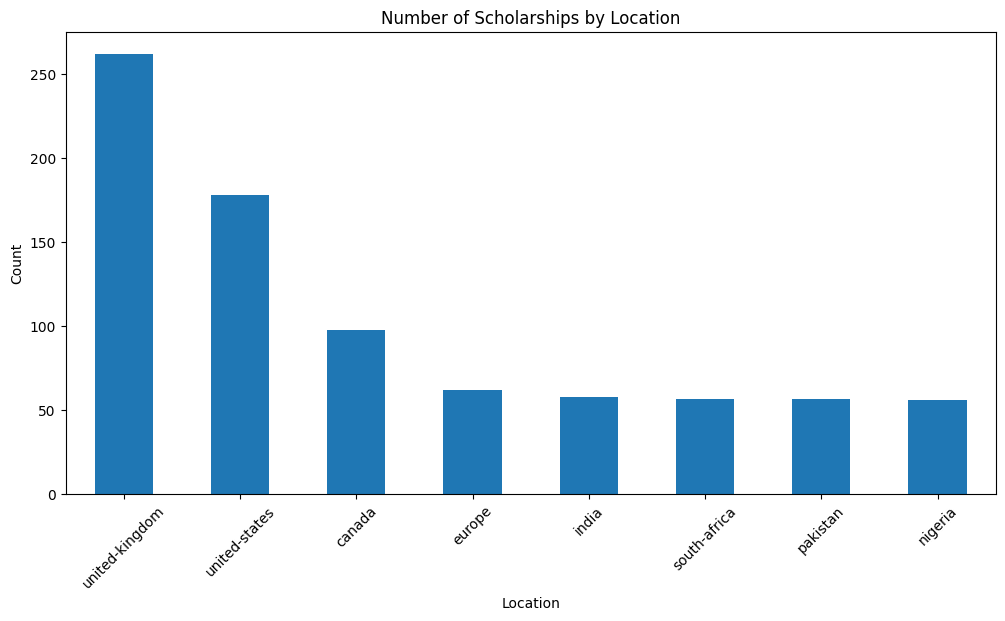

In [99]:
import matplotlib.pyplot as plt


# Calculate the frequency of each location
location_counts = jawwad_df['location'].value_counts()

# Plotting the scholarship counts for all locations
plt.figure(figsize=(12, 6))
location_counts.plot(kind='bar')
plt.title("Number of Scholarships by Location")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Calculating the frequency of highest location (country)

In [95]:
# Calculating the frequency of highest location
location_counts = jawwad_df['location'].value_counts()

# Identify the location with the highest number of scholarships
highest_location = location_counts.idxmax()
highest_count = location_counts.max()

# Filter the dataset based on the highest location
filtered_df = jawwad_df[jawwad_df['location'] == highest_location]

# Calculate the frequency of each scholarship title within the filtered dataset
title_counts = filtered_df['title'].value_counts()

# Identify the scholarship title with the highest count
highest_title = title_counts.idxmax()
highest_title_count = title_counts.max()

# Print the results
print("Location with the highest number of scholarships:", highest_location)
print("Number of scholarships in the highest location:", highest_count)
print("Scholarship title with the highest count in the highest location:", highest_title)
print("Count of the highest title in the highest location:", highest_title_count)

Location with the highest number of scholarships: united-kingdom
Number of scholarships in the highest location: 262
Scholarship title with the highest count in the highest location: The Keith Murray Senior Scholarship
Count of the highest title in the highest location: 1


### Performing different types of operations for scholarships of U.K.

In [101]:
uk_scholarships = jawwad_df[jawwad_df['location'] == 'united-kingdom']
# Count the number of unique titles
num_titles_uk = uk_scholarships['title'].nunique()

# Print the number of titles
print("Number of titles for scholarships in the UK:", num_titles_uk)

Number of titles for scholarships in the UK: 262


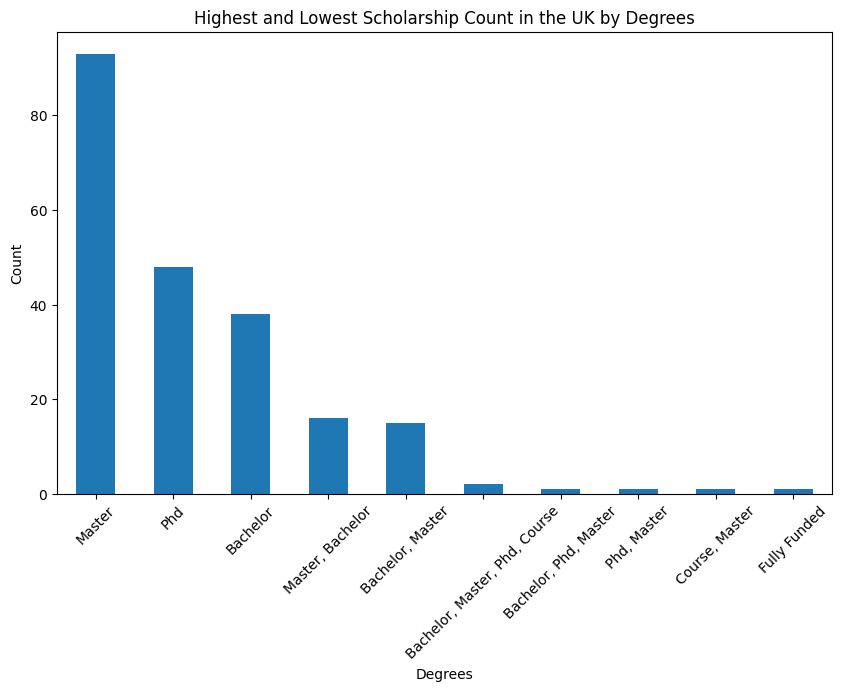

In [103]:
# Calculate the scholarship count for each degree and funds
degree_funds_counts = uk_scholarships.groupby(['degrees', 'funds']).size().unstack()

# Find the degrees with the highest and lowest count
highest_degrees = degree_funds_counts.sum(axis=1).nlargest(5).index
lowest_degrees = degree_funds_counts.sum(axis=1).nsmallest(5).index

# Filter the dataset for the highest and lowest degrees
filtered_scholarships = uk_scholarships[uk_scholarships['degrees'].isin(highest_degrees.union(lowest_degrees))]

# Create a grouped bar chart
plt.figure(figsize=(10, 6))
filtered_scholarships['degrees'].value_counts().plot(kind='bar')
plt.title('Highest and Lowest Scholarship Count in the UK by Degrees')
plt.xlabel('Degrees')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [105]:
# Filter the dataset for fully funded scholarships
fully_funded_scholarships = uk_scholarships[uk_scholarships['funds'] == 'Fully Funded']

# Count the degrees with the most number of fully funded scholarships
degrees_counts = fully_funded_scholarships['degrees'].value_counts()

# Get the degree(s) with the highest count
highest_degrees = degrees_counts.nlargest(1)

# Filter the dataset for the degree(s) with the highest count
filtered_scholarships = fully_funded_scholarships[fully_funded_scholarships['degrees'].isin(highest_degrees.index)]

# Count the scholarships by location for the highest degree(s)
location_counts = filtered_scholarships['location'].value_counts()

# Display the degrees with the highest count and their corresponding locations
print("Degrees with the most number of fully funded scholarships:")
for degree, count in highest_degrees.items():
    print("Degree:", degree)
    print("Count:", count)
    print("Locations:")
    for location, location_count in location_counts.items():
        print(f"- {location}: {location_count}")
    print()

Degrees with the most number of fully funded scholarships:
Degree: Phd
Count: 18
Locations:
- united-kingdom: 18



In [106]:
# Filter the dataset for fully funded scholarships
fully_funded_scholarships = uk_scholarships[uk_scholarships['funds'] == 'Full cost of UK tuition fees and an annual stipend']

# Count the degrees with the most number of fully funded scholarships
degree_counts = fully_funded_scholarships['degrees'].value_counts()

# Get the degree(s) with the highest count
highest_degrees = degree_counts[degree_counts == degree_counts.max()].index

# Filter the fully funded scholarships dataset for the highest degrees
filtered_scholarships = fully_funded_scholarships[fully_funded_scholarships['degrees'].isin(highest_degrees)]

# Group the data by degree, location, and title and calculate the count
grouped_data = filtered_scholarships.groupby(['degrees', 'location', 'title']).size().reset_index(name='count')

# Sort the data by count in descending order
sorted_data = grouped_data.sort_values('count', ascending=False)

# Print the degrees with the most number of fully funded scholarships, along with the location and title
print("Degrees with the fully funded scholarships:")
for _, row in sorted_data.iterrows():
    print("Degree:", row['degrees'])
    print("Location:", row['location'])
    print("Title:", row['title'])
    print()

Degrees with the fully funded scholarships:
Degree: Phd
Location: united-kingdom
Title: Biosciences: Fully Funded PhD Scholarship at Swansea: Seagrass Restoration

Degree: Phd
Location: united-kingdom
Title: Engineering: Fully Funded EPSRC PhD Scholarship at Swansea University: solid-state batteries

Degree: Phd
Location: united-kingdom
Title: Materials Engineering: Fully Funded Swansea University and CISM PhD: Advanced Dielectrics

Degree: Phd
Location: united-kingdom
Title: Medical Engineering: Fully Funded EPSRC PhD Scholarship: AI approaches to cell imaging data

Degree: Phd
Location: united-kingdom
Title: Nanotechnology: Fully Funded Swansea University and European Commission PhD

Degree: Phd
Location: united-kingdom
Title: Physics: Fully Funded PhD Scholarship at Swansea: Photovoltaic Applications

Degree: Phd
Location: united-kingdom
Title: Sports Science: Fully Funded PhD at Swansea: The effect of mineral rich Algae

Degree: Phd
Location: united-kingdom
Title: Sports Science: F